# 3rd time is the charm aaaa moment

I'm going to reshape the dataframe, focusing only on the "Close" prices before, since in attempt2 something went wrong.


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

ticker = "AAPL"  # again, Apple stock symbol, change here
start_date = "2010-01-01"
split_date = "2023-12-31"
end_date = "2024-01-31"
data_train = yf.download(ticker, start=start_date, end=split_date)
data_test = yf.download(ticker, start=split_date, end=end_date)

# ill attempt to to handle them separately

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Conversion to numpy arrays

In [16]:
prices_train = data_train['Close'].values.reshape(-1, 1)
prices_test = data_test['Close'].values.reshape(-1, 1)

prices_train[0:5] # equivalent to .head()

array([[7.64321423],
       [7.65642881],
       [7.53464317],
       [7.52071381],
       [7.570714  ]])

In [15]:
prices_test[0:5]

array([[185.63999939],
       [184.25      ],
       [181.91000366],
       [181.17999268],
       [185.55999756]])

## Normalize the data and train test
Using MinMax Scaler, explanations are on the other attempts.

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices_train = scaler.fit_transform(prices_train)
scaled_prices_test = scaler.fit_transform(prices_test)

## Create sequences (for the LSTM)

In [22]:
# Define sequence creation function
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])  # Look-back window
        y.append(data[i])             # Target value
    return np.array(X), np.array(y)

# Set look-back period
look_back = 10

In [23]:
X_train, y_train = create_sequences(scaled_prices_train, look_back)
X_test, y_test = create_sequences(np.concatenate((scaled_prices_train[-look_back:], scaled_prices_test)), look_back)


## Build the model

In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential([
    LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0317 - val_loss: 0.2021
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7720e-04 - val_loss: 0.1966
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5036e-04 - val_loss: 0.1955
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1346e-04 - val_loss: 0.1903
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0050e-04 - val_loss: 0.1900
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9415e-04 - val_loss: 0.1882
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0814e-04 - val_loss: 0.1817
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3011e-04 - val_loss: 0.1840
Epoch 9/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9598e-04 - val_loss: 0.1768
Epoch 10/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8650e-04 - val_loss: 0.1743
Epoch 11/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9616e-04 - val_loss: 0.1710
Epoch 12/20


## Evaluate the model

In [32]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')


Train Loss: 0.000160
Test Loss: 0.140983


In [33]:
# Predict closing prices
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Denormalize the predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
y_train_unscaled = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test_unscaled = scaler.inverse_transform(y_test)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


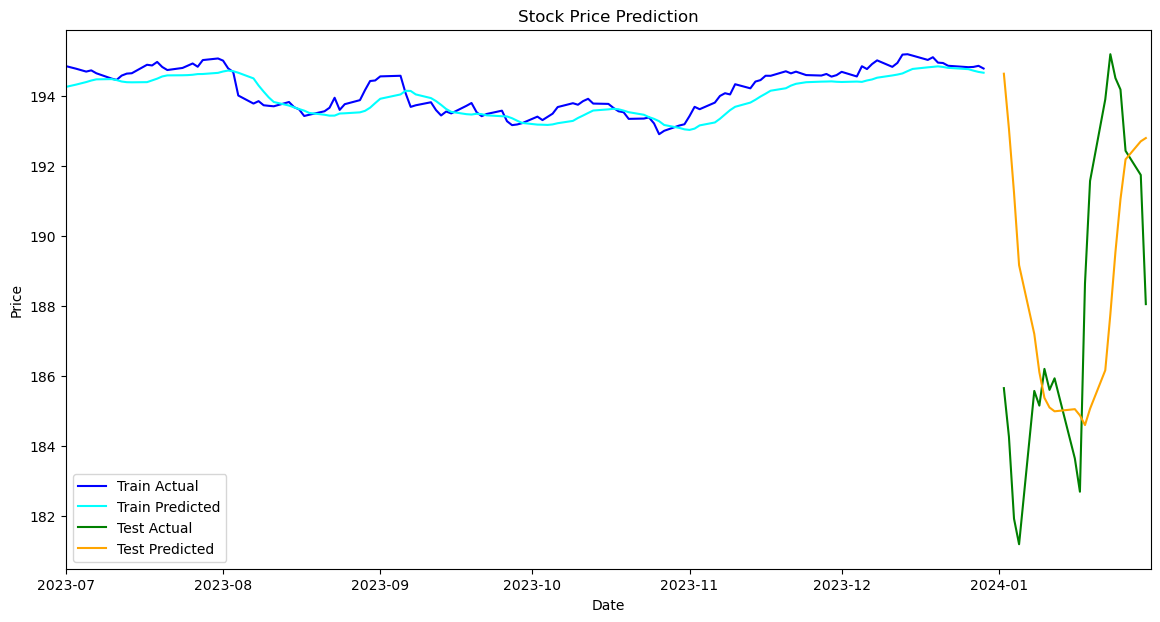

In [37]:
# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot training data predictions
plt.plot(data_train.index[look_back:], y_train_unscaled.squeeze(), label="Train Actual", color='blue')
plt.plot(data_train.index[look_back:], train_predictions.squeeze(), label="Train Predicted", color='cyan')

# Plot test data predictions
test_dates = data_test.index[:len(y_test_unscaled)]  # Align test dates with test sequences
plt.plot(test_dates, y_test_unscaled.squeeze(), label="Test Actual", color='green')
plt.plot(test_dates, test_predictions.squeeze(), label="Test Predicted", color='orange')

# Zoom in on 2022 and later
plt.xlim(pd.Timestamp("2023-07-01"), pd.Timestamp("2024-01-31"))

plt.title("Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
